## This is a project to comapare different state of the art GANs

This notebook is inspired by [Generative Adverserail Networks(GANS](https://www.coursera.org/specializations/generative-adversarial-networks-gans) by Deeplearnig.ai

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
from torchvision.utils import save_image

#### Getting the data

The images are normalised to Mean 0 and Standard deviation as 1.

In [2]:
dataset= FashionMNIST(root= 'data', 
               train=True, 
               download=True,
               transform= Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))


In [3]:
img=dataset[0][0]
img.shape

torch.Size([1, 28, 28])

#### Creating batches of DATA

In [4]:
batch_size= 100
dataset_real_dl= DataLoader(dataset=dataset, 
                            batch_size=batch_size, 
                            shuffle=True)


#### Denormalising the image to view it!

In [5]:
def denorm(img):
    denorm_img=(img+1)/2
    
    return denorm_img


#### Visualising the DATA

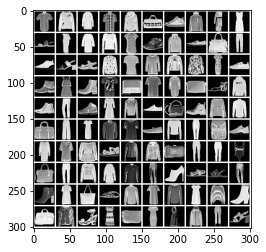

In [6]:
from torchvision.utils import make_grid, save_image

for imgs, lables in dataset_real_dl:
    grid= make_grid(denorm(imgs), nrow=10, pad_value=2)
    plt.imshow(grid.clamp(0,1).permute(1,2,0))
    plt.show()
    break

In [31]:
r_size= 100
hidden_size= [256, 256]
in_size= 28*28
out_size= 1
rand_vect_std= torch.randn(10, r_size)

G_layers=[]
G_layers.append(r_size)
for h in hidden_size:
    G_layers.append(h)
G_layers.append(in_size)

D_layers= []
D_layers.append(in_size)
for h in hidden_size[::-1]:
    D_layers.append(h)
D_layers.append(out_size)


In [32]:
class Generator(nn.Module):
    def __init__(self, G_layers):
        super().__init__()
        self.G_layers= G_layers
        self.G_model_list= []
        for i, (in_size, out_size) in enumerate(zip(self.G_layers, self.G_layers[1:])):
            if i<len(self.G_layers)-1:
                self.G_model_list.append(self.getG_Layer(in_size, out_size))
            else:
                self.model_list.append(self.getG_Layer(in_size, out_size, final_layer= True))
        self.G_model= nn.Sequential(*self.G_model_list)
                
    def getG_Layer(self,in_size, out_size, final_layer= False):
        if not final_layer:
            model= nn.Sequential(nn.Linear(in_size, out_size), nn.ReLU())
        else:
            model= nn.Sequential(nn.Linear(in_size, out_size), nn.Tanh())
        return model
    def forward(self, rand_vect):
        fake_img= self.G_model(rand_vect)
        return fake_img.reshape(-1, 1, 28, 28)
    

In [44]:
class Discriminator(nn.Module):
    def __init__(self, D_layers, W_Gan= False):
        super().__init__()
        self.D_layers= D_layers
        self.W_Gan= W_Gan
        self.D_model_list= []
        for i, (in_size, out_size) in enumerate(zip(self.D_layers, self.D_layers[1:])):
            if i<len(self.D_layers)-1:
                self.D_model_list.append(self.getD_Layer(in_size, out_size))
            else:
                self.D_model_list.append(self.getD_Layer(in_size, out_size, final_layer= True))
        self.D_model= nn.Sequential(*self.model_list)
                
    def getD_Layer(self,in_size, out_size, final_layer= False):
        if not final_layer:
            model= nn.Sequential(nn.Linear(in_size, out_size), nn.LeakyReLU(0.2))
        elif self.W_Gan:
            model= nn.Linear(in_size, out_size)           
        else:
            model= nn.Sequential(nn.Linear(in_size, out_size), nn.Sigmoid())
        return model
    def forward(self, img):
        return self.D_model(img.view(-1, self.D_layers[0]))
        

In [56]:
def getFakeImages(G):
    rand_vect= torch.randn(batch_size, r_size)
    return G(rand_vect)

def save_fake_imgs(gan_type,epoch):
    samples_dir='samples/'
    if not os.path.exists(samples_dir):
        os.mkdir(samples_dir)

    fake_imgs= G(rand_vect_std).detach()
    fake_imgs_name= '{:s}/fake_images-{:0=4d}.png'.format(gan_type, epoch)
    print('saving fake_image:', fake_imgs_name)
    save_image(denorm(fake_imgs), samples_dir+fake_imgs_name, nrow=10)

#### Original Gans Formulation

In [59]:
class Original_Gan(Generator, Discriminator):
    def __init__(self, dataset_real_dl, G_layers, D_layers, W_Gan= False):
        Generator.__init__(self, G_layers)
        Discriminator.__init__(self, D_layers, W_Gan)
        
        self.dataset_real_dl= dataset_real_dl
        self.gan_type= 'Original_Gan'
    
        self.G_opt= torch.optim.SGD(self.G_model.parameters(), lr= 2e-2)
        self.D_opt= torch.optim.SGD(self.D_model.parameters(), lr= 2e-2)
    def Train_D(self, real_imgs):
        fake_imgs= getFakeImages(self.G_model)
        D_loss= nn.BCELoss(self.D_model(real_imgs), torch.ones(batch_size,1))+ \
                nn.BCELoss(self.D_model(fake_imgs), torch.zeros(batch_size, 1))
        self.D_opt.zero_grad()
        self.D_loss.backward()
        self.D_opt.step()
        return D_loss.item()
    def Train_G(self):
        fake_imgs= getFakeImages(self.G_model)
        G_loss= -nn.BCELoss(self.D_model(fake_imgs), torch.zeros(batch_size,1))
        self.G_opt.zero_grad()
        self.G_loss.backward()
        self.G_opt.step()
        return G_loss.item()
    def Train_Original_Gan(self, epochs=60):
        for epoch in epochs:
            for imgs,_ in self.dataset_real_dl:
                D_loss= self.Train_D(imgs)
                G_loss= self.Train_G()
            save_fake_imgs(self.gan_type, epoch)
            

In [60]:
Org_Gan= Original_Gan(dataset_real_dl)
Org_Gan.Train_Original_Gan(10)

TypeError: __init__() missing 1 required positional argument: 'layers'

In [71]:
class P:
    def __init__(self):
        print("hello its P")
        self.a=[]
        self.a.append(3)
    def demo(self, i):
        d=self.a[i]
        return d
p= P()
l= p.demo(0)

hello its P


In [ ]:
class R:
    def __init__(self, c):
        print("hello its R")
        self.a= c
class Q(P):
    def __init__(self, b, c):
        P.__init__(self, b)
        R.__init__(self, c)
        print(self.a)
        
Z= Q(2,3)
    